In [1]:
# from dsc 80
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display, IFrame, HTML

import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# DSC 80 preferred styles
pio.templates["dsc80"] = go.layout.Template(
    layout=dict(
        margin=dict(l=30, r=30, t=30, b=30),
        autosize=True,
        width=600,
        height=400,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+dsc80"

set_matplotlib_formats("svg")
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# display options for numpy and pandas
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Use plotly as default plotting engine
pd.options.plotting.backend = "plotly"

### others
from pathlib import Path
pio.renderers.default = "browser"

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

This is a data science project about League of Legends for the class DSC 80 at UCSD. 

Names: Joyce Hu and Ellie Wang

# Introduction

For our project, we are interested in exploring dataset about the game League of Legends from Oracle's Elixir. As League of Legends continues to constantly update the game, there are changes to all aspects that we want to investigate. More specifically, we aim to answer qusetions about the champion Neeko.

# Data Cleaning and Exploratory Data Analysis

For our project, we worked with smaller dataframes taken from `league`, which is the dataframe that concats together League of Legends datasets from Oracle's Elixir from the years 2021, 2022, 2023, and 2024. To appropriately clean the data, we:

- created `patch_missing`: a new column that holds a binary variable for missing patches 
- imputed missing patches by mapping specific dates to corresponding patch versions
- imputed team statistics; team-level statistics for certain variables (`firstdragon`, `firstherald`, `heralds`, `opp_heralds`) are imputed into missing player-level stats by extracting team summary stats from the dataset and merging them with player-level data based on `gameid` and `teamid`
- created `post_rework`: binary variable for patch rework; checks if patch is greater than or equal to 13.09 
- created `neeko`: binary variable to indicate whether Neeko played n the game 
- created `herald_diff`: represents the difference in number of heralds gained by the team and the opponent team 
- kept the features we need for the rest of the project 


We cleaned the dataset this way to make the data more compatible to  answer our question: is there a higher proportion of games with a Neeko in it after the Patch 13.9 rework? 



In [2]:
fp1 = '../data/league_2021.csv'
fp2 = '../data/league_2022.csv'
fp3 = '../data/league_2023.csv'
fp4 = '../data/league_2024.csv'

leeg21 = pd.read_csv(fp1)
leeg22 = pd.read_csv(fp2)
leeg23 = pd.read_csv(fp3)
leeg24 = pd.read_csv(fp4)

league = pd.concat([leeg21, leeg22, leeg23, leeg24])
league.head()

/Users/joycehu/miniforge3/envs/dsc80/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,...,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,...,1.0,0.0,1.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,...,0.0,2.0,0.0,3.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,...,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,...,2.0,1.0,1.0,2.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,...,0.0,0.0,2.0,2.0


In [3]:
# make copy 
pre_cleaning = league.copy()

# binary variable for missing patch
league['patch_missing'] = (league['patch'].isna()).astype(int)

## impute missing patches
patches = {
    '2022-08-11 08:37:33':12.15, 
    '2022-08-12 06:08:39':12.15, 
    '2022-08-12 07:04:40':12.15, 
    '2022-08-12 07:52:33':12.15, 
    '2022-08-12 08:51:49':12.15, 
    '2022-08-12 09:58:13':12.15, 
    '2022-08-13 06:08:31':12.15, 
    '2022-08-13 06:55:35':12.15, 
    '2022-08-13 06:08:31':12.15,
    '2022-08-13 06:55:35':12.15,
    '2022-08-13 07:47:42':12.15,
    '2023-04-05 09:17:28':13.07,
    '2023-04-05 10:18:03':13.07, 
    '2023-04-05 11:23:10':13.07,
    '2023-04-05 12:21:13':13.07,
    '2023-04-05 13:10:18':13.07,
    '2023-05-08 06:12:19':13.09,
    '2023-05-08 07:07:13':13.09,
    '2023-05-08 08:12:21':13.09,
    '2023-05-08 09:06:19':13.09,
    '2023-05-08 10:08:36':13.09,
    '2024-02-21 06:02:57':14.03,
    '2024-02-21 06:56:52':14.03, 
    '2024-02-21 07:43:27':14.03,
    '2024-02-21 08:31:33':14.03, 
    '2024-02-21 09:17:02':14.03
}
league['patch'] = league['patch'].fillna(league['date'])
league['patch'] = league['patch'].replace(patches)

## impute team statistics into missing player level stats for 'firstdragon', 'firstherald', 'heralds', 'opp_heralds'

# get team summary statistics 
team_stats = (league[(league['participantid'] == 100) | (league['participantid'] == 200)]
              .loc[:,['gameid', 'teamid','firstdragon', 'firstherald', 'heralds', 'opp_heralds']])

# subset dataframe to player level data
league = league[(league['participantid'] != 100) & (league['participantid'] != 200)]

# drop stats cols in league to retain col names after merge
league = league.drop(columns=['firstdragon', 'firstherald', 'heralds', 'opp_heralds'])

# merge team stats onto player level data
league = league.merge(team_stats, on=['gameid', 'teamid'], how='left')

# create a binary variable for before and after Patch 13.9
league['post_rework'] = (league['patch'] >= 13.09).astype(int)

# create a binary variable for whether neeko played in the game
league['neeko'] = (league['champion'] == 'Neeko').astype(int)

# create a new variable for difference in heralds gained 
league['herald_diff'] = league['heralds'] - league['opp_heralds']

# keep features we need
league = (league.loc[:, ['gameid', 'teamid', 'neeko', 'position', 'datacompleteness','league', 
                'patch', 'patch_missing','firstdragon', 'firstherald', 'herald_diff', 'goldat15','xpat15','csat15',
                'golddiffat15','xpdiffat15','csdiffat15','killsat15','assistsat15','deathsat15',
                'result', 'post_rework']])

league.head()

,gameid,teamid,neeko,position,...,assistsat15,deathsat15,result,post_rework
0,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,top,...,0.0,1.0,1,0
1,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,jng,...,2.0,0.0,1,0
2,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,mid,...,3.0,0.0,1,0
3,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,bot,...,4.0,2.0,1,0
4,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,sup,...,4.0,0.0,1,0


In [4]:
# print(league.head().to_markdown(index = False))

## Univariate Analysis
This plot shows the distribution of positions that Neeko played. From the plot, we can see that `mid` is the most played position by Neeko. 

In [5]:
neeko = league[league['neeko'] == 1]

fig_uni = px.histogram(neeko, x='position')
fig_uni.update_layout(title_text = "Histogram of Neeko's Positions Played")

          
# fig_uni.show()
# fig_uni.write_html
# fig_uni.write_html('univariate.html', include_plotlyjs='cdn')

In [47]:
fig_gold = px.histogram(neeko, 'goldat15')
fig_gold.update_layout(title_text = "Histogram of Neeko's Gold At 15")

## Bivariate Analysis

This plot (Neeko only) shows the relationship between the column `goldat15` and `csat15`, which are the amount of gold collected at 15 minutes and the number of minions killed at 15 minutes by Neeko. We can see a positive correlation between the two variables since as the amount of gold collected increases, the number of minions killed increases as well. 

In [6]:
fig_bi = px.scatter(neeko, x='goldat15', y='csat15',
                 title='Distribution of Gold v. CS at 15 Minutes')

fig_bi.update_xaxes(title='Gold at 15 Minutes')
fig_bi.update_yaxes(title='CS at 15 Minutes')

# fig_bi.show()
# fig_bi.write_html
# fig_bi.write_html('bivariate.html', include_plotlyjs='cdn')

In [49]:
px.scatter(neeko, 'xpat15', 'csat15', title='Relationship between XP and CS at 15')

## Interesting Aggregates

This is a pivot table of the number of games with neeko from patch 12.10 to 14.05, seperated by the position she was played in. It is interesting because we can see the amount of games she was played in increases over time. 

In [7]:
# just looking at patch 12.10 - present
recent = league[league['patch'] >= 12.10]

recent_pv = (recent.pivot_table(index='patch', columns='position', values='neeko', aggfunc='sum', 
                    margins=True, margins_name='total'))

# print(recent_pv.to_markdown())
# recent.pivot_table

In [8]:
league['patch_missing']

0         0
1         0
2         0
         ..
382837    0
382838    0
382839    0
Name: patch_missing, Length: 382840, dtype: int64

# Assessment of Missingness

## NMAR Analysis

We do not belive that there is a column in our dataset that is NMAR. While there are a lot of columns with missing data, we believe that most are related to the column `datacompletedness`. 

Additionally, based on our preliminary findings when looking at the "patch" column that has missing data, we believe that the column "league", which is composed of the different leagues played in the game, could explain the missingness since we found that there were only missing patches for two leagues out of the 56.

## Missingness Dependency: `patch`

A column that is important to our hypothesis test is the `patch` column. However, we found that the `patch` column had **382840** missing values. We analyzed its relationship with the `league` and `result` columns to check its missingness dependency. 

### 1. `patch` v. `league`


In [9]:
piv = league.pivot_table(index='league', columns='patch_missing', aggfunc='size').fillna(0)
piv = piv / piv.sum()
obs1 = piv.diff(axis=1).iloc[:,-1].abs().sum() / 2
print(obs1)
piv.head()

0.8441191845269211


patch_missing,0,1
league,,
AL,5.78e-03,0.0
AOL,9.67e-04,0.0
BIG,3.87e-03,0.0
BL,2.69e-03,0.0
BM,2.30e-03,0.0


In [10]:
n_repetitions = 500
shuffled = league.loc[:,['league', 'patch_missing']]

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether patch is missing
    shuffled['shuffle_patch'] = np.random.permutation(shuffled['patch_missing'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='league', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

[0.20215891270256142,
 0.2215673462275658,
 0.20552143230527967,
 0.19762023000522738,
 0.1931325143753267,
 0.1802343613870012,
 0.20230920020909565,
 0.1799468548527618,
 0.21216849625370274,
 0.23282496950688275]

#### p-value: 

In [11]:
(np.array(tvds) >= obs1).mean()

0.0

**Conclusion:**
- Since our p-value = 0.0 which is less than our alpha value of 0.5, we conclude that the missingness of `patch` **does** depend on `league`.

In [12]:
fig1 = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD (patch v. league)')
fig1.add_vline(x=obs1, line_color='red')
fig1.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs1, 2)}</span>',
                   x=1 * obs1, showarrow=False, y=0.16)
fig1.update_layout(yaxis_range=[0, 0.2])
# fig.write_html
# fig.write_html('patch1.html', include_plotlyjs='cdn')

In [13]:
patch1 = league[['patch_missing', 'league']]


fig1_2 = px.histogram(patch1, x='league', color='patch_missing', histnorm='probability', marginal='box',
             title="League by Missingness of Patch", barmode='overlay', opacity=0.7)

fig1_2.write_html
fig1_2.write_html('patch1_2.html', include_plotlyjs='cdn')

### 2. `patch` v. `result`

In [14]:
piv = league.pivot_table(index='result', columns='patch_missing', aggfunc='size').fillna(0)
piv = piv / piv.sum()
obs2 = piv.diff(axis=1).iloc[:,-1].abs().sum() / 2

print(obs2)
piv

0.00014375326711968395


patch_missing,0,1
result,,
0,0.5,0.5
1,0.5,0.5


In [15]:
n_repetitions = 500
shuffled = league.loc[:,['result', 'patch_missing']]

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether patch is missing
    shuffled['shuffle_patch'] = np.random.permutation(shuffled['patch_missing'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='result', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

[0.012651594354417123,
 0.004025527095312759,
 0.004313033629552154,
 0.03737976999477258,
 0.012364087820177727,
 0.01682087471684965,
 0.025159435441714617,
 0.012651594354417123,
 0.08352936051576929,
 0.06685223906603935]

**p-value:**

In [16]:
(np.array(tvds) >= obs2).mean()

1.0

**Conclusion:**
Since our p-value = 1.0 which is greater than our alpha level of 0.05, we can conclude that the missingness of `patch` **does not** depend on the `result` column. 

In [17]:
fig_2 = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD (patch v. result)')
fig_2.add_vline(x=obs2, line_color='red')
fig_2.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs2, 2)}</span>',
                   x=2.3 * obs2, showarrow=False, y=0.16)
fig_2.update_layout(yaxis_range=[0, 0.2])
fig_2.show()
# fig.write_html
# fig.write_html('patch2.html', include_plotlyjs='cdn')

In [18]:
patch2 = league[['patch_missing', 'result']]


fig2_2 = px.histogram(patch2, x='result', color='patch_missing', histnorm='probability', marginal='box',
             title="Result by Missingness of Patch", barmode='overlay', opacity=0.7)
fig2_2.show()
fig2_2.write_html
fig2_2.write_html('fig2_2.html', include_plotlyjs='cdn')

## Hypothesis Testing
**Question**: Is there a higher proportion of games with a Neeko in it after the Patch 13.9 rework?

**Null**: There is no difference in proportion of games with Neeko before and after the Patch 13.9 rework.


**Alternative**: There is a higher proportion of games with Neeko after the Patch 13.9 rework. 


**Test Statistic**: Difference in Proportion, more specifically the proportion of games with Neeko after minus before the patch 13.9
- We chose difference in proportion because our data is categorical and directional.
- Our observed statistic: 0.1404526229251691

**Significance Level**: 0.05
- This is a standard hypothesis test. 


**Result p-value**: 0
- We ran 10,000 repetitions. 

**Conclusion**: As the p-value is 0, we reject the null hypothesis in favor of the alternative hypothesis, which is that there is a higher proportion of games with Neeko after the Patch 13.9 rework. 


In [19]:
# create a new df where each observation is a game (game id becomes unique)
rework = league.groupby('gameid').agg({'post_rework': 'first', 'neeko':'sum'})
rework


,post_rework,neeko
gameid,,
10000-10000_game_1,0,0
10000-10000_game_2,0,0
10000-10000_game_3,0,0
...,...,...
NA1_4493591166,0,0
NA1_4493652706,0,0
NA1_4493722220,0,0


In [20]:
# observed value is the proportion of games with neeko after - before the patch
obs_rework = rework.groupby('post_rework').mean().diff().iloc[-1][0]
obs_rework

0.1392589611416802

In [21]:
n_reps = 10_000
diffs = []

for _ in range(n_reps):
    
    # shuffle rework column 
    rework['shuffled_rework'] = np.random.permutation(rework['post_rework'])
    
    # compute test statistic 
    difference = rework.groupby('shuffled_rework').mean().diff().iloc[-1][0]
    
    diffs.append(difference)

diffs[:10]

[0.004465577319813979,
 0.0058772379160203225,
 0.0069751961575141574,
 -0.002279023306505229,
 0.0007011490632637118,
 -0.0038475350800678265,
 -0.0030632791932865,
 -0.0016516185970801844,
 -0.002435874483861483,
 -0.006827707449836767]

In [22]:
# calculate p-value
(np.array(diffs) >= obs_rework).mean()

0.0

In [23]:
# hypo_test = px.histogram(pd.DataFrame(diffs), x=0, nbins=50, histnorm='probability', 
#                    title='Empirical Distribution of the TVD')
# hypo_test.add_vline(x=obs_rework, line_color='red')
# hypo_test.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs2, 2)}</span>',
#                    x=2.3 * obs2, showarrow=False, y=0.16)
# hypo_test.update_layout(yaxis_range=[0, 0.2])
# fig.write_html
# fig.write_html('hypo_test.html', include_plotlyjs='cdn')

# Prediction
#### Can we predict whether Neeko's team wins the game based on her stats at 15 minutes?
Our prediction problem focuses on trying to predict whether Neeko's team can win the game at 15 minutes because that is when the team can choose to forfeit the game if they think they will lose. 

For our prediction problem, we are performing binary classification. Our response variable is the `result` column, where the values represent whether Neeko's team won the game or not. We chose this variable because it is a interpretable measure of success (win or loss) and aligns well with our objective of prediciting the game outcomes. 

The metric we chose for evaluating the model's performance is recall because it is more harmful to the team to forfeit when they could have won. False positives are less harmful because even if they lose later on, forfeiting is a guaranteed loss. However, we will also consider the F1-score just to make sure there is balance between the recall and precision of our model. 

We will include 2021 data in our training model to include more data into the model. It is not a concern because Neeko doesn't change much between seasons. 

In [24]:
# include 2021 data 
neeko = league[league['neeko']==1]
# get rid of partial
neeko = neeko[(neeko['datacompleteness']=='complete') & (neeko['patch'] >= 11.07)]
neeko.head()

,gameid,teamid,neeko,position,...,assistsat15,deathsat15,result,post_rework
50657,NA1/3859085355,oe:team:4fe384f3e93db8f9a984f06a3c75e6c,1,mid,...,1.0,3.0,0,0
57517,ESPORTSTMNT01/2002464,oe:team:65140c73015d004b0456fb43ba373a4,1,mid,...,0.0,1.0,0,0
57722,NA1/3916799284,oe:team:9548eb0ae58f318888c036712da329b,1,mid,...,0.0,1.0,0,0
59177,NA1/3927500028,oe:team:47b7394e386b2ab9bb97100fe136098,1,mid,...,0.0,0.0,0,0
137267,ESPORTSTMNT02_2557639,oe:team:1ab54595dac94e054c4f3831f7ccb98,1,mid,...,3.0,0.0,1,0


In [25]:
# we should get above 53% accuracy!
neeko['result'].value_counts(normalize=True)

1    0.53
0    0.47
Name: result, dtype: float64

### Setting Up Data

In [26]:
stats_15 = ['goldat15','xpat15', 'csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15','killsat15', 'assistsat15', 'deathsat15']
variables = ['position', 'patch', 'firstdragon', 'firstherald', 'herald_diff', 'goldat15',
       'xpat15', 'csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15',
       'killsat15', 'assistsat15', 'deathsat15']
features = neeko.loc[:, variables] 
target = neeko['result']  

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12)

### Baseline Model

**Here is a list with explanations of the columns we will be looking at for our baseline model:**

`goldat15`: Total amount of gold accumulated by Neeko at 15 minutes.

`xpat15`: Total amount of experience points earned by Neeko at 15 minutes. 

`csat15`: Total number of minion kills by Neeko's **team** at 15 minutes. 

`killsat15`: Total number of enemy champions killed by Neeko at 15 minutes. 

`assistsat15`:	Total number of assists obtained by Neeko at 15 minutes. 

`deathsat15`: Total number of deaths of Neeko at 15 minutes.

`position`: Neeko's position in the game (`bot`, `top`, `mid`, `sup`, and `jng`) 


Our baseline model is a binary classifier that predicts whether Neeko's team wins the game or not given features recorded at 15 minutes of the game. 

For the baseline, we included nominal features, which are the one-hot encoded columns of Neeko's position, and the quantitative columns of Neeko's gold, experience points, number of minions, deaths, kills, and assists at 15 minutes. 

We performed the one hot endcoding using the `OneHotEncoder()` method from scikit-learn.

In [27]:
# feature engineering 
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['position']),
    ('passthrough', 'passthrough', ['goldat15','xpat15','csat15','killsat15','assistsat15','deathsat15'])
], remainder='drop')

pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', LogisticRegression(max_iter = 10000))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
print("Train set accuracy:", pipeline.score(X_train, y_train))
print("Test set accuracy:", pipeline.score(X_test, y_test))  
print()
print("Train set recall:", metrics.recall_score(y_train, pipeline.predict(X_train)))
print("Test set recall:", metrics.recall_score(y_test, pipeline.predict(X_test)))
print()
print("Train set F1:", metrics.f1_score(y_train, pipeline.predict(X_train)))
print("Test set F1:", metrics.f1_score(y_test, pipeline.predict(X_test)))

Train set accuracy: 0.6491228070175439
Test set accuracy: 0.6612903225806451

Train set recall: 0.7448453608247423
Test set recall: 0.7941176470588235

Train set F1: 0.6897374701670644
Test set F1: 0.72


### Baseline Model Analysis

The test set recall is 0.79 and its F1 score is 0.72, so its overall performance is pretty good but can still be inmproved. The recall and F1 scores are also similar to its training scores so it is unlikely that it is overfitting. 

To improve on the model, we will add a new variable, `herald_diff`, which indicates how many more rift heralds the opposing team has. We will also add binary variables for whether Neeko or her opponent was performing better at 15 minutes. Lastly, we will standardize some of the numeric columns so we can know how much better in general her stats are at 15 minutes that in other games. We believe that these new features can give more information for the Logistic Regression model. 

Furthermore, we will search for the best threshold for the model. 

In [28]:
# feature engineering
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['position']),
    ('binarize', Binarizer(threshold=0), ['golddiffat15','xpdiffat15','csdiffat15']),
    ('standard', StandardScaler(), stats_15 + ['herald_diff'])
], remainder='passthrough')

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', LogisticRegression(max_iter = 10000))
])

pipeline.fit(X_train, y_train)

# Finding the best threshold 
thresholds = np.arange(0.01, 1.01, 0.01)
precisions = np.array([])
recalls = np.array([])

for t in thresholds:
    y_pred = pipeline.predict_proba(X_test)[:, 1] >= t
    precisions = np.append(precisions, metrics.precision_score(y_test, y_pred, zero_division=1))
    recalls = np.append(recalls, metrics.recall_score(y_test, y_pred))

px.line(x=recalls, y=precisions, hover_name=thresholds, 
        labels={'x': 'Recall', 'y': 'Precision'}, title='Precision vs. Recall')

In [29]:
print("Using Best Threshold: ")
best_threshold = 0.58

y_pred_train = pipeline.predict_proba(X_train)[:, 1] >= best_threshold
y_pred_test = pipeline.predict_proba(X_test)[:, 1] >= best_threshold

# Evaluate the pipeline
print("Train set accuracy:", metrics.accuracy_score(y_train, y_pred_train))
print("Test set accuracy:", metrics.accuracy_score(y_test, y_pred_test))
print()
print("Train set recall:", metrics.recall_score(y_pred_train, y_train))
print("Test set recall:", metrics.recall_score(y_pred_test, y_test))
print()

print("Train set f1:", metrics.f1_score(y_pred_train, y_train))
print("Test set f1:", metrics.f1_score(y_pred_test, y_test))

Using Best Threshold: 
Train set accuracy: 0.6923076923076923
Test set accuracy: 0.7150537634408602

Train set recall: 0.7424242424242424
Test set recall: 0.7816091954022989

Train set f1: 0.6824512534818942
Test set f1: 0.7195767195767195


The model using the best threshold and the new features did not improve the recall or the F1 score, so we will test out some other models. 

### Random Forest

We tried fitting a Random Forest Classifier next to see if it would be better at the prediction task. 

In [30]:
pipeline = Pipeline([
    ('preprocessor', ct),
    ('random-forest', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

print("Train set accuracy:", pipeline.score(X_train, y_train))
print("Test set accuracy:", pipeline.score(X_test, y_test))
print()
print("Train set recall:", metrics.recall_score(pipeline.predict(X_train), y_train))
print("Test set recall:", metrics.recall_score(pipeline.predict(X_test), y_test))
print()

print("Train set f1:", metrics.f1_score(pipeline.predict(X_train), y_train))
print("Test set f1:", metrics.f1_score(pipeline.predict(X_test), y_test))

Train set accuracy: 1.0
Test set accuracy: 0.6827956989247311

Train set recall: 1.0
Test set recall: 0.7362637362637363

Train set f1: 1.0
Test set f1: 0.6943005181347152


It also performed worse than the baseline model for the training set. Moreover, the Train set had perfect accuracy, recall, and F1 scores. This indicated to use that the model might be overfitting. So, we decided to tune the hyperparameters using `GridSearchCV` to find the best `min_samples_split`, `max_depth`, and `criterion`.  

We also removed the `Binarizer` step from the pre-processing because we realized that binarizing the numeric variables might have removed helpful information from the model. 

In [31]:
hyperparameters = {
    'random-forest__min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'random-forest__max_depth': np.arange(2, 200, 20),
    'random-forest__criterion': ['gini', 'entropy']
}

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['position']),
    ('standard', StandardScaler(), stats_15 + ['herald_diff'])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', ct),
    ('random-forest', RandomForestClassifier(random_state=12))
])

grids = GridSearchCV(
    pipeline,
    n_jobs=-1, 
    param_grid=hyperparameters,
    return_train_score=True, 
    cv=5
)
grids.fit(X_train, y_train)

# Evaluate the pipeline
print("Train set accuracy:", grids.score(X_train, y_train))
print("Test set accuracy:", grids.score(X_test, y_test))
print()

print("Train set recall:", metrics.recall_score(grids.predict(X_train), y_train))
print("Test set recall:", metrics.recall_score(grids.predict(X_test), y_test))
print()

print("Train set f1:", metrics.f1_score(grids.predict(X_train), y_train))
print("Test set f1:", metrics.f1_score(grids.predict(X_test), y_test))


Train set accuracy: 0.8070175438596491
Test set accuracy: 0.7150537634408602

Train set recall: 0.8024691358024691
Test set recall: 0.7474747474747475

Train set f1: 0.8196721311475409
Test set f1: 0.736318407960199


In [32]:
grids.best_params_

{'random-forest__criterion': 'entropy',
 'random-forest__max_depth': 22,
 'random-forest__min_samples_split': 40}

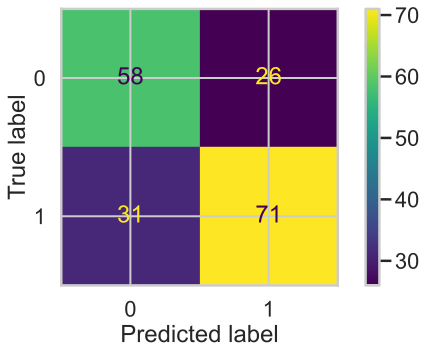

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
fig = ConfusionMatrixDisplay.from_estimator(pipeline.fit(X_train, y_train), X_test, y_test);

## Final Model

In the end, we decided to choose the `RandomForestClassifier` model with tuned hyperparameters (`criterion` = 'entropy', `max_depth` = 22, and `min_samples_split` = 40) as the final model.  
Although our base model actually had a higher recall score (testing set = 0.79), this final model has a higher F1 score (0.74) and a much better accuracy (0.72). Since we still do care about False Positives too, we decided to go with the model with the higher F1 score overall. 

Our final model probably performed better than the Baseline model because we added more features and preprocessing steps. Also, a `RandomForestClassifier` fits many trees to find the best prediction. 

# Fairness Analysis

#### Does our model perform better for Tier 1 leagues than non-Tier 1 leagues?

**Null Hypothesis**: Our model is fair. Its F1 score for Tier 1 leagues and non-Tier 1 leagues are roughly the same, and any differences are due to random chance.  
Alternative Hypothesis: Our model is unfair. Its F1 score for non-Tier 1 leagues are lower than its F1 score for Tier 1 leagues.  

**Evaluation Metric**: Our evaluation metric is the F1 score because we want to balance between not having too many false positives or negatives. 

**Test Statistic**: Difference in F1 Scores

**Significance Level**: 0.01

In [34]:
t1 = ['LCK', 'LPL', 'LEC', 'LCS', 'PCS', 'VCS', 'CBLOL', 'LLA']
neeko['tier1'] = (neeko['league'].isin(t1)).astype(int)

In [35]:
results = pd.merge(X_test, neeko.loc[:,['tier1']], left_index=True, right_index=True, how='left')
results['prediction'] = grids.predict(X_test)
results['result'] = y_test
results.head()

,position,patch,firstdragon,firstherald,...,deathsat15,tier1,prediction,result
377347,mid,14.04,1.0,1.0,...,0.0,0,1,1
362047,mid,14.02,1.0,1.0,...,1.0,1,1,0
310952,mid,13.11,0.0,1.0,...,0.0,0,0,1
310561,jng,13.11,1.0,1.0,...,0.0,1,1,1
375977,mid,14.04,1.0,0.0,...,0.0,0,1,1


In [36]:
compute_f1 = lambda x: metrics.f1_score(x['result'], x['prediction'])
(
    results
    .groupby('tier1')
    .apply(compute_f1)
    .rename('f1 score')
)

tier1
0    0.74
1    0.74
Name: f1 score, dtype: float64

In [37]:
obs = results.groupby('tier1').apply(compute_f1).diff().iloc[-1]
obs

0.0031674208144796268

In [38]:
diff_in_f1 = []
for _ in range(500):
    s = (
        results[['tier1', 'prediction', 'result']]
        .assign(tier1=np.random.permutation(results['tier1']))
        .groupby('tier1')
        .apply(compute_f1)
        .diff()
        .iloc[-1]
    )
    
    diff_in_f1.append(s)

In [39]:
(np.array(diff_in_f1) >= obs).mean()

0.478

In [40]:
fig = pd.Series(diff_in_f1).plot(kind='hist', histnorm='probability', nbins=25,
                            title='Difference in F1 Score for Tier 1 vs Non-Tier 1 Leagues')
fig.update_layout(xaxis_range=[-1, 1])
fig.add_vline(x=obs, line_color='red', line_width=2, opacity=1)

From our p-value of 0.508, we fail to reject our null hypothesis. There does not seem to be any significant differences in our model's F1 prediction scores for Tier 1 and non-Tier 1 leagues. Thus, it appears that our model achieves accuracy parity for these two groups.